#LOGISTIC REGRESSION
Στη λογιστική παλινδρόμηση εκπαιδεύουμε ένα γραμμικό μοντέλο που, μέσω της softmax δίνει πιθανότητες για κάθε κλάση. Σε κάθε epoch κάνουμε shuffle στα δεδομένα και ενημερώνουμε τα βάρη με SGD, δηλαδή με μικρές ενημερώσεις ανά δείγμα. Επίσης γίνεται κανονικοποίηση των δεδομένων με StandardScalar. Για να υπολογίσουμε σωστά το σφάλμα στο multiclass, χρησιμοποιούμε Cross Entropy loss. Σε κάθε epoch κρατάμε το loss τόσο στο train όσο και στο test set και το απεικονίζουμε σε γράφημα, ώστε να βλέπουμε την πορεία εκπαίδευσης. Τέλος, υπολογίζουμε accuracy και classification report για να αξιολογήσουμε την απόδοση του μοντέλου. Γενικώς ο αλγόριθμος είναι γραμμικός ταξινομητής στο feature space

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Custom Logistic Regression algorithm---
Train Accuracy: 0.9930
Test Accuracy : 1.0000

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



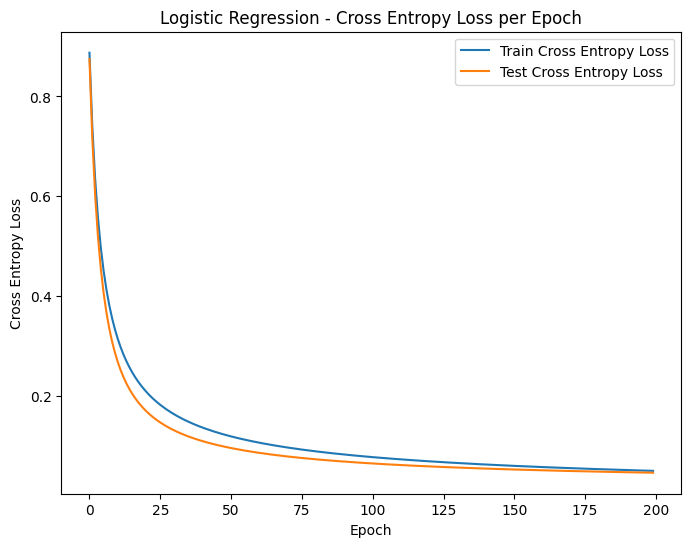

In [4]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

file_path = '/content/drive/MyDrive/wine_dataset.csv'


class LogisticRegression:

    def __init__(self, lr=0.001, n_epochs=200, n_classes=3):
        self.lr = lr
        self.n_epochs = n_epochs
        self.weights = None
        self.bias = None
        self.n_classes = n_classes

        self.train_losses = []
        self.test_losses = []

    def fit(self, X_train, y_train, X_test=None, y_test=None):
        n_samples, n_features = X_train.shape
        self.weights = np.zeros((n_features, self.n_classes))
        self.bias = np.zeros(self.n_classes)

        for epoch in range(self.n_epochs):

            #The training data are randomly shuffled at every epoch and
            #the model parameters are updated AFTER EACH INDIVIDUAL SAMPLE.
            #so Stochastic Gradient Descent (SGD).
            idx = np.random.permutation(n_samples)
            X_shuf = X_train[idx]
            y_shuf = y_train[idx]

            for i in range(n_samples):
                x_i = X_shuf[i:i+1]
                y_i = y_shuf[i]

                linear_model = np.dot(x_i, self.weights) + self.bias   #(1, K)
                y_pred = self.softmax(linear_model)                   #(1, K)


                y_onehot = np.zeros((1, self.n_classes))
                y_onehot[0, y_i] = 1.0


                gw = np.dot(x_i.T, (y_pred - y_onehot))               #(n_features, K)
                gb = (y_pred - y_onehot).reshape(-1)                  #(K,)

                #update
                self.weights -= self.lr * gw
                self.bias -= self.lr * gb

            # -------Cross entropy loss ανά epoch----
            train_loss = self.cross_entropy(X_train, y_train)
            self.train_losses.append(train_loss)

            if X_test is not None and y_test is not None:
                test_loss = self.cross_entropy(X_test, y_test)
                self.test_losses.append(test_loss)

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(linear_model)
        return np.argmax(y_pred, axis=1)

    def softmax(self, x, ax=1):
        m = np.max(x, axis=ax, keepdims=True)
        p = np.exp(x - m)
        return p / np.sum(p, axis=ax, keepdims=True)

    def cross_entropy(self, X, y):
        #y: ints, X: (n, d)
        linear_model = np.dot(X, self.weights) + self.bias
        probs = self.softmax(linear_model)
        eps = 1e-9
        return -np.mean(np.log(probs[np.arange(len(y)), y] + eps))


df = pd.read_csv(file_path)

X = df.drop('target', axis=1).values
y = df['target'].values.astype(int)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print("\n--- Custom Logistic Regression algorithm---")

#model
model = LogisticRegression(
    lr=0.001,
    n_epochs=200,
    n_classes=3
)

#training
model.fit(X_train, y_train, X_test, y_test)

#predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)


print(f"Train Accuracy: {accuracy_score(y_train, train_preds):.4f}")
print(f"Test Accuracy : {accuracy_score(y_test, test_preds):.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_preds))

plt.figure(figsize=(8,6))
plt.plot(model.train_losses, label='Train Cross Entropy Loss')
plt.plot(model.test_losses, label='Test Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Logistic Regression - Cross Entropy Loss per Epoch')
plt.legend()
plt.show()
